In [80]:
# import necessary packages:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

# [A] define the methods for functional connectivity:

In [81]:
# [2] define partial correlation through OLS:
from scipy import stats, linalg
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [82]:
# [3] define measures of similarity:
def euclidean_distance(x,y): 
    """ return euclidean distance between two lists """ 
    return math.sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
 
def manhattan_distance(x,y): 
    """ return manhattan distance between two lists """ 
    return sum(abs(a-b) for a,b in zip(x,y))

In [83]:
# [4] MUTUAL INFORMATION:
from sklearn.metrics import mutual_info_score

import numpy as np

def calc_MI(X,Y,bins):
   c_XY = np.histogram2d(X,Y,bins)[0]
   c_X = np.histogram(X,bins)[0]
   c_Y = np.histogram(Y,bins)[0]

   H_X = shan_entropy(c_X)
   H_Y = shan_entropy(c_Y)
   H_XY = shan_entropy(c_XY)

   MI = H_X + H_Y - H_XY
   return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

# [B] compute functional connectivity on the resting state dataset, with the aforementioned methods:

In [84]:
# load the fMRI data:
#df1    = pd.read_csv("100307_restingstate_day1.csv")
df1    = pd.read_csv("../datasets/stock_data/detrended-log.csv", sep=',', parse_dates=True, index_col='date')

#print df1
#df1 = df1.dropna().transpose()
df1 = df1.astype(float)

'''
par = 10
for col in list(df1):
    df1['ma'] = df1[col].rolling(par,center=False).mean().bfill()
    df1[col] = df1[col]-df1['ma']
 
df1 = df1.drop('ma', 1)
df1 = df1.drop('population', 1)
print df1
'''

data1  = df1.values
Nvars  = data1.shape[1]

#import os
#cwd = os.getcwd()
#print cwd

#labels_Glasser  = pd.read_csv("../datasets/fMRI/labels_Glasser.csv",header=None)[0].tolist()
labels_Glasser  = list(df1)

df1 = df1[labels_Glasser[0:100]]

print df1

                 ABT       AET       APD       AXP       AIG      AMGN  \
date                                                                     
1993-12-15 -0.009306 -0.020643 -0.007888 -0.028514  0.004442  0.000000   
1993-12-16 -0.008465 -0.001576 -0.008465 -0.008725 -0.001426  0.010664   
1993-12-17  0.013514  0.009558  0.005267  0.008725  0.004350  0.000000   
1993-12-20  0.012533  0.011100  0.003198  0.015793  0.002955 -0.016081   
1993-12-21  0.000000 -0.017421  0.000000  0.019740 -0.007304  0.023243   
1993-12-22  0.017379 -0.003237 -0.005828 -0.011273  0.013188  0.005272   
1993-12-23  0.008968 -0.011297  0.000000  0.008459 -0.017716  0.020855   
1993-12-27  0.012038  0.004792  0.019465  0.015288  0.007337  0.037172   
1993-12-28 -0.008022  0.022397 -0.000441 -0.019493  0.000000  0.031041   
1993-12-29  0.000000  0.009476 -0.019538 -0.004254 -0.001384  0.022248   
1993-12-30 -0.017072 -0.009476 -0.013914  0.008459  0.000000 -0.012637   
1993-12-31  0.013056  0.003169  0.0000

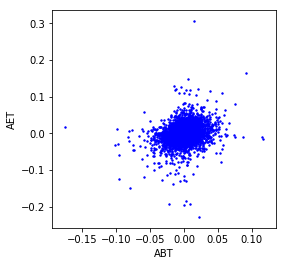

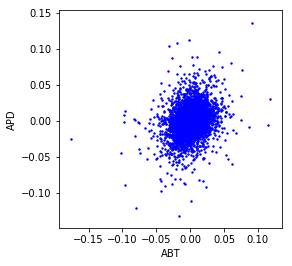

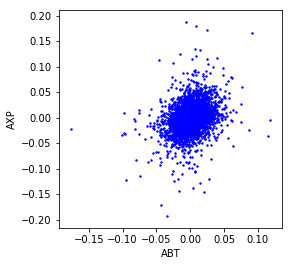

In [85]:
# check the linearity between variables:
plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,1], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[1])
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,2], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[2])
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,3], color='b', s=2)
plt.xlabel(labels_Glasser[0])
plt.ylabel(labels_Glasser[3])
plt.show()

In [86]:
# shorten the datasets to 800 samples, in order to make them comparable with the visual stimulation task if necessary:
# list1 = np.ndarray.tolist(np.arange(400))
# list2 = np.ndarray.tolist(1200+np.arange(400))
# indexes = list(itertools.chain(list1, list2)) 
# data1 = data1[indexes,:]

In [87]:
import itertools

# [1] PEARSON'S R:
pearsonr        = np.zeros((Nvars,Nvars))
pearsonr_p      = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr[ind1,ind2],pearsonr_p[ind1,ind2]) = scipy.stats.pearsonr(data1[:,ind1], data1[:,ind2])

# [2A] PARTIAL CORRELATION THROUGH OLS REGRESSION:
# warning: this one is slooooow:
# partial_correlation1 = partial_corr(data)

# [2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
# partial_correlation = partial_corr(data)
covariance_matrix = np.cov(np.transpose(data1))
inv_cov = np.linalg.inv(covariance_matrix)
partial_correlation2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation2[ind1,ind2] = - inv_cov[ind1,ind2]/np.sqrt((inv_cov[ind1,ind1])*(inv_cov[ind2,ind2]))
        
# [3] MEASURES OF SIMILARITY:
euclidean = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        euclidean[ind1,ind2] = euclidean_distance(data1[:,ind1], data1[:,ind2])

manhattan = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        manhattan[ind1,ind2] = manhattan_distance(data1[:,ind1], data1[:,ind2])

# [4] MUTUAL INFORMATION:        
# you need to specify the number of bins (which is a shortcoming of mutual information):
bins = 10
matMI = np.zeros((Nvars,Nvars))

for ix in np.arange(Nvars):
    for jx in np.arange(ix+1,Nvars):
        matMI[ix,jx] = calc_MI(data1[:,ix], data1[:,jx], bins)
        matMI[jx,ix] = matMI[ix,jx]

In [88]:
# [C] plot the functional connectomes:

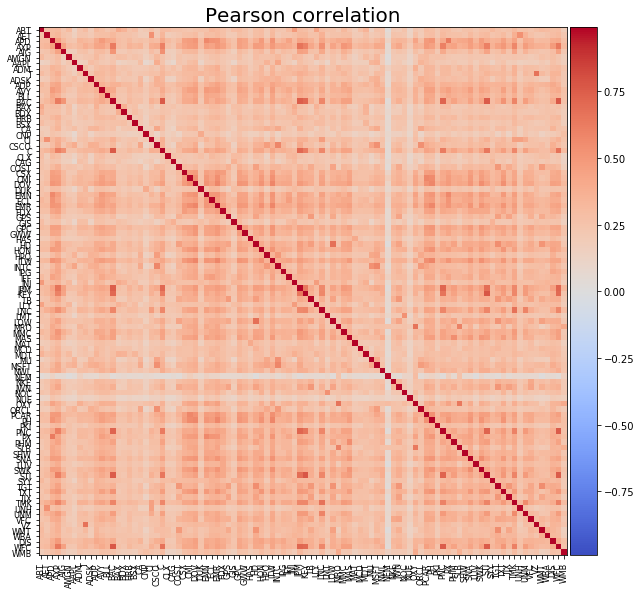

In [89]:
# [1] PEARSON'S R:
f = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(pearsonr, clim=[-0.99,0.99],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Pearson correlation', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

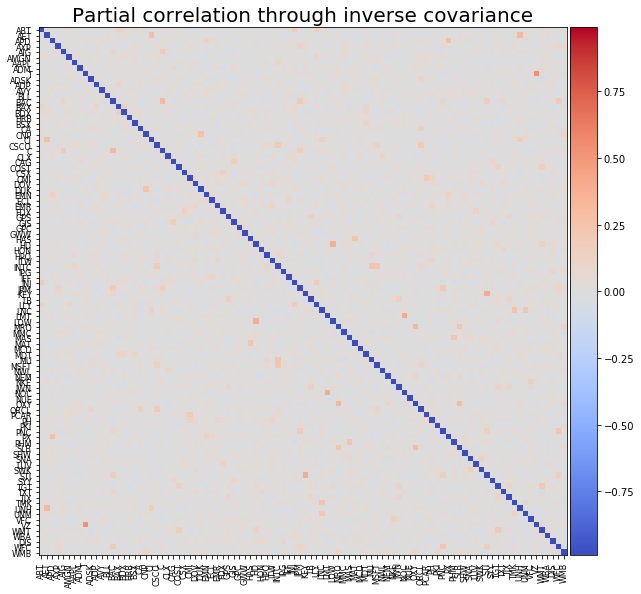

In [90]:
#[2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
f = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(partial_correlation2, clim=[-0.99,0.99],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Partial correlation through inverse covariance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

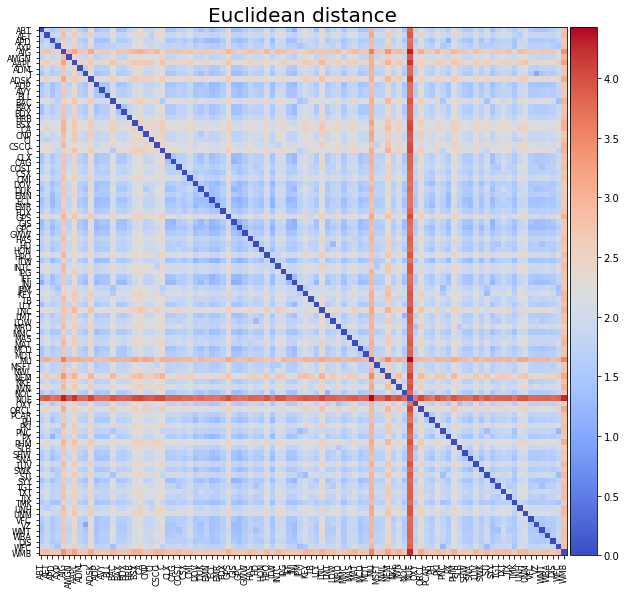

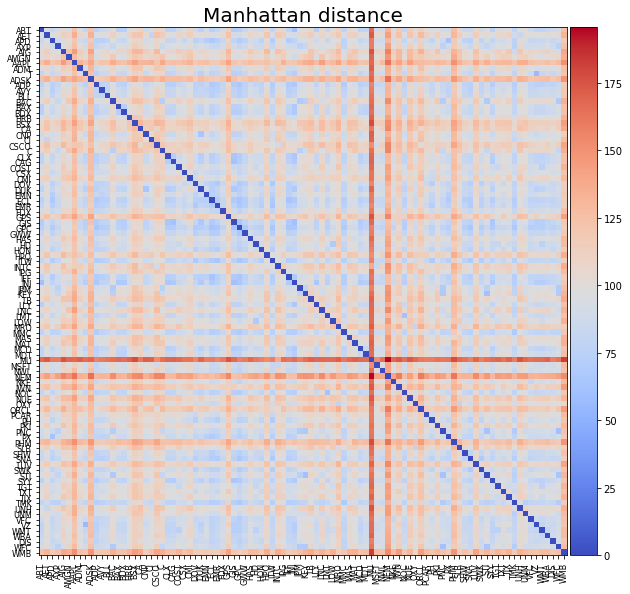

In [91]:
# [C] MEASURES OF SIMILARITY:
f = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(euclidean, cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Euclidean distance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


f = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(manhattan, cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Manhattan distance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

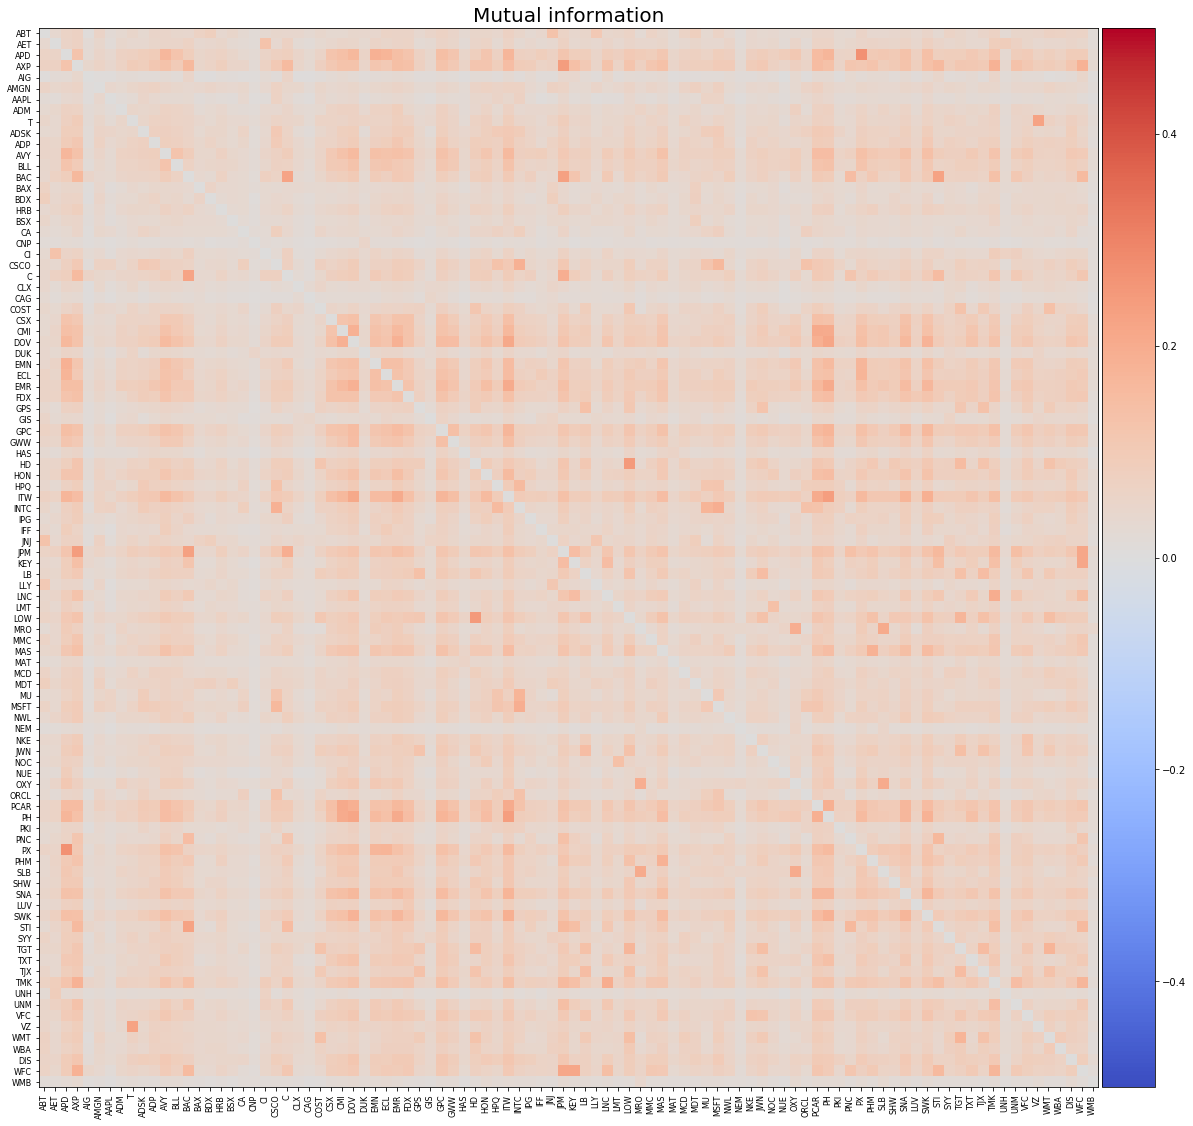

In [92]:
# [4] MUTUAL INFORMATION:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(matMI, clim=[-0.5,0.5],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Mutual information', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [93]:
'''
# [D] partial correlation between between two participnats, 
# and between resting state, two days of scanning and the visual working memory task:
# load the fMRI data:
list1 = np.ndarray.tolist(np.arange(400))
list2 = np.ndarray.tolist(1200+np.arange(400))

import itertools
indexes = list(itertools.chain(list1, list2)) #list(set(indexes_female + indexes_male_matched))


df2    = pd.read_csv("100307_restingstate_day2.csv")
data2  = df2.values
data2  = data2[indexes,:]

df3    = pd.read_csv("100307_WMtask.csv")
data3  = df3.values

df4    = pd.read_csv("100408_restingstate_day1.csv")
data4  = df4.values
data4  = data4[indexes,:]

df5    = pd.read_csv("100408_restingstate_day2.csv")
data5  = df5.values
data5  = data5[indexes,:]

df6    = pd.read_csv("100408_WMtask.csv")
data6  = df6.values

pearsonr_data2 = np.zeros((Nvars,Nvars))
pearsonr_p_data2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data2[ind1,ind2],pearsonr_p_data2[ind1,ind2]) = scipy.stats.pearsonr(data2[:,ind1], data2[:,ind2])

pearsonr_data3 = np.zeros((Nvars,Nvars))
pearsonr_p_data3 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data3[ind1,ind2],pearsonr_p_data3[ind1,ind2]) = scipy.stats.pearsonr(data3[:,ind1], data3[:,ind2]) 
        
pearsonr_data4 = np.zeros((Nvars,Nvars))
pearsonr_p_data4 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data4[ind1,ind2],pearsonr_p_data4[ind1,ind2]) = scipy.stats.pearsonr(data4[:,ind1], data4[:,ind2])

pearsonr_data5 = np.zeros((Nvars,Nvars))
pearsonr_p_data5 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data5[ind1,ind2],pearsonr_p_data5[ind1,ind2]) = scipy.stats.pearsonr(data5[:,ind1], data5[:,ind2]) 

pearsonr_data6 = np.zeros((Nvars,Nvars))
pearsonr_p_data6 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr_data6[ind1,ind2],pearsonr_p_data6[ind1,ind2]) = scipy.stats.pearsonr(data6[:,ind1], data6[:,ind2])
'''

'\n# [D] partial correlation between between two participnats, \n# and between resting state, two days of scanning and the visual working memory task:\n# load the fMRI data:\nlist1 = np.ndarray.tolist(np.arange(400))\nlist2 = np.ndarray.tolist(1200+np.arange(400))\n\nimport itertools\nindexes = list(itertools.chain(list1, list2)) #list(set(indexes_female + indexes_male_matched))\n\n\ndf2    = pd.read_csv("100307_restingstate_day2.csv")\ndata2  = df2.values\ndata2  = data2[indexes,:]\n\ndf3    = pd.read_csv("100307_WMtask.csv")\ndata3  = df3.values\n\ndf4    = pd.read_csv("100408_restingstate_day1.csv")\ndata4  = df4.values\ndata4  = data4[indexes,:]\n\ndf5    = pd.read_csv("100408_restingstate_day2.csv")\ndata5  = df5.values\ndata5  = data5[indexes,:]\n\ndf6    = pd.read_csv("100408_WMtask.csv")\ndata6  = df6.values\n\npearsonr_data2 = np.zeros((Nvars,Nvars))\npearsonr_p_data2 = np.zeros((Nvars,Nvars))\nfor ind1 in range(Nvars):\n    for ind2 in range(Nvars):\n        (pearsonr_data2[i

In [94]:
'''f, axarr = plt.subplots(2,3,figsize=(15,15))
plt.suptitle('Correlation')
axarr[0, 0].imshow(pearsonr, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 0].set_title('resting state day 1, subject 100307')
axarr[0, 1].imshow(pearsonr_data2, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 1].set_title('resting state day 2, subject 100307')
axarr[0, 2].imshow(pearsonr_data3, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 2].set_title('Working Memory task, subject 100307')
axarr[1, 0].imshow(pearsonr_data4, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 0].set_title('resting state day 1, subject 100408')
axarr[1, 1].imshow(pearsonr_data5, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 1].set_title('resting state day 2, subject 100408')
axarr[1, 2].imshow(pearsonr_data6, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 2].set_title('Working Memory task, subject 100408')
plt.show()
'''

"f, axarr = plt.subplots(2,3,figsize=(15,15))\nplt.suptitle('Correlation')\naxarr[0, 0].imshow(pearsonr, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 0].set_title('resting state day 1, subject 100307')\naxarr[0, 1].imshow(pearsonr_data2, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 1].set_title('resting state day 2, subject 100307')\naxarr[0, 2].imshow(pearsonr_data3, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 2].set_title('Working Memory task, subject 100307')\naxarr[1, 0].imshow(pearsonr_data4, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 0].set_title('resting state day 1, subject 100408')\naxarr[1, 1].imshow(pearsonr_data5, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 1].set_title('resting state day 2, subject 100408')\naxarr[1, 2].imshow(pearsonr_data6, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 2].set_title('Working Memory task, subject 100408')\nplt.show()\n"

In [95]:
'''
# the same for partial correlation:
# comparison between between two participants, and between resting state, two days of scanning and the visual working memory task:
# load the fMRI data:

covariance_matrix_data1 = np.cov(np.transpose(data1))
inv_cov_data1 = np.linalg.inv(covariance_matrix_data1)
partial_correlation_data1 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data1[ind1,ind2] = - inv_cov_data1[ind1,ind2]/np.sqrt((inv_cov_data1[ind1,ind1])*(inv_cov_data1[ind2,ind2]))

covariance_matrix_data2 = np.cov(np.transpose(data2))
inv_cov_data2 = np.linalg.inv(covariance_matrix_data2)
partial_correlation_data2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data2[ind1,ind2] = - inv_cov_data2[ind1,ind2]/np.sqrt((inv_cov_data2[ind1,ind1])*(inv_cov_data2[ind2,ind2]))

covariance_matrix_data3 = np.cov(np.transpose(data3))
inv_cov_data3 = np.linalg.inv(covariance_matrix_data3)
partial_correlation_data3 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data3[ind1,ind2] = - inv_cov_data3[ind1,ind2]/np.sqrt((inv_cov_data3[ind1,ind1])*(inv_cov_data3[ind2,ind2]))

covariance_matrix_data4 = np.cov(np.transpose(data4))
inv_cov_data4 = np.linalg.inv(covariance_matrix_data4)
partial_correlation_data4 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data4[ind1,ind2] = - inv_cov_data4[ind1,ind2]/np.sqrt((inv_cov_data4[ind1,ind1])*(inv_cov_data4[ind2,ind2]))

covariance_matrix_data5 = np.cov(np.transpose(data5))
inv_cov_data5 = np.linalg.inv(covariance_matrix_data5)
partial_correlation_data5 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data5[ind1,ind2] = - inv_cov_data5[ind1,ind2]/np.sqrt((inv_cov_data5[ind1,ind1])*(inv_cov_data5[ind2,ind2]))

covariance_matrix_data6 = np.cov(np.transpose(data6))
inv_cov_data6 = np.linalg.inv(covariance_matrix_data6)
partial_correlation_data6 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation_data6[ind1,ind2] = - inv_cov_data6[ind1,ind2]/np.sqrt((inv_cov_data6[ind1,ind1])*(inv_cov_data6[ind2,ind2]))
'''

'\n# the same for partial correlation:\n# comparison between between two participants, and between resting state, two days of scanning and the visual working memory task:\n# load the fMRI data:\n\ncovariance_matrix_data1 = np.cov(np.transpose(data1))\ninv_cov_data1 = np.linalg.inv(covariance_matrix_data1)\npartial_correlation_data1 = np.zeros((Nvars,Nvars))\nfor ind1 in range(Nvars):\n    for ind2 in range(Nvars):\n        partial_correlation_data1[ind1,ind2] = - inv_cov_data1[ind1,ind2]/np.sqrt((inv_cov_data1[ind1,ind1])*(inv_cov_data1[ind2,ind2]))\n\ncovariance_matrix_data2 = np.cov(np.transpose(data2))\ninv_cov_data2 = np.linalg.inv(covariance_matrix_data2)\npartial_correlation_data2 = np.zeros((Nvars,Nvars))\nfor ind1 in range(Nvars):\n    for ind2 in range(Nvars):\n        partial_correlation_data2[ind1,ind2] = - inv_cov_data2[ind1,ind2]/np.sqrt((inv_cov_data2[ind1,ind1])*(inv_cov_data2[ind2,ind2]))\n\ncovariance_matrix_data3 = np.cov(np.transpose(data3))\ninv_cov_data3 = np.linal

In [96]:
'''
f, axarr = plt.subplots(2,3,figsize=(15,15))
plt.suptitle('Partial correlation')
axarr[0, 0].imshow(partial_correlation_data1, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 0].set_title('resting state day 1, subject 100307')
axarr[0, 1].imshow(partial_correlation_data2, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 1].set_title('resting state day 2, subject 100307')
axarr[0, 2].imshow(partial_correlation_data3, cmap='coolwarm', clim=[-0.5,0.5])
axarr[0, 2].set_title('Working Memory task, subject 100307')
axarr[1, 0].imshow(partial_correlation_data4, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 0].set_title('resting state day 1, subject 100408')
axarr[1, 1].imshow(partial_correlation_data5, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 1].set_title('resting state day 2, subject 100408')
axarr[1, 2].imshow(partial_correlation_data6, cmap='coolwarm', clim=[-0.5,0.5])
axarr[1, 2].set_title('Working Memory task, subject 100408')
plt.show()
'''

"\nf, axarr = plt.subplots(2,3,figsize=(15,15))\nplt.suptitle('Partial correlation')\naxarr[0, 0].imshow(partial_correlation_data1, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 0].set_title('resting state day 1, subject 100307')\naxarr[0, 1].imshow(partial_correlation_data2, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 1].set_title('resting state day 2, subject 100307')\naxarr[0, 2].imshow(partial_correlation_data3, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[0, 2].set_title('Working Memory task, subject 100307')\naxarr[1, 0].imshow(partial_correlation_data4, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 0].set_title('resting state day 1, subject 100408')\naxarr[1, 1].imshow(partial_correlation_data5, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 1].set_title('resting state day 2, subject 100408')\naxarr[1, 2].imshow(partial_correlation_data6, cmap='coolwarm', clim=[-0.5,0.5])\naxarr[1, 2].set_title('Working Memory task, subject 100408')\nplt.show()\n"

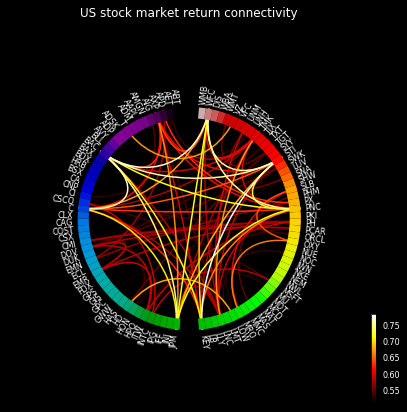

In [97]:
# [E] plot circular connectomes:
# on the basis of online tutorial:
# https://www.martinos.org/mne/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html
# https://www.martinos.org/mne/stable/generated/mne.viz.plot_connectivity_circle.html#mne.viz.plot_connectivity_circle
    
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

label_names = labels_Glasser
node_order = []
node_order.extend(labels_Glasser)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig = plot_connectivity_circle(pearsonr, label_names, n_lines=100, colorbar=True,
                         node_angles=node_angles, #node_colors=label_colors, 
                         title='US stock market return connectivity')

#plt.show()
#plt.savefig('stocks.png',dpi=200)